In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import predict

%matplotlib inline

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    print(train_dataset["train_set_x"])
    print(train_dataset["train_set_y"])
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
        
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # (1080,) --> (1, 1080)
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

<HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">
<HDF5 dataset "train_set_y": shape (1080,), type "<i8">


In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, Y.shape[1]))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [4]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

y = 2


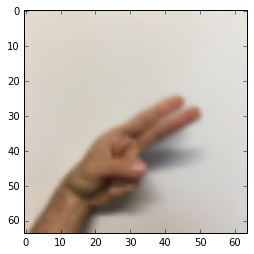

In [5]:
# Example of a picture
index = 2
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [6]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 12288
number of test examples = 12288
X_train shape: (1080, 12288)
Y_train shape: (1080, 6)
X_test shape: (120, 12288)
Y_test shape: (120, 6)


In [7]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [None, n_x] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(None, n_x), name = 'X')
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name = 'Y')
    
    return X, Y

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #k is kernel

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 150, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (number of training examples = 1080, input size = 12288)
    Y_train -- test set, of shape (number of training examples = 1080, output size = 6)
    X_test -- training set, of shape (number of training examples = 120, input size = 12288)
    Y_test -- test set, of shape (number of test examples = 120, output size = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
#     ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
#     tf.set_random_seed(1)                             # to keep consistent results
#     seed = 3                                          # to keep consistent results
    (m, n_x) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[1]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    
    x_image = tf.reshape (X, [-1,64,64,3], name="x_image") #change input data from a list to a 64 x 64 x 3 RGB cube 
    
    # Define layers
    W_conv1 = weight_variable([5, 5, 3, 32]) #32 features for each 5x5 size of filer, 3 channels RGB
    b_conv1 = bias_variable([32])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # convolution
    h_pool1 = max_pool_2x2(h_conv1) # max pooling
    W_conv2 = weight_variable([5, 5, 32, 64]) #64 features
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
        
    # Fully Connected Layer
    W_fc1 = weight_variable([16 * 16 * 64, 1024]) # 16x16 images by 64 features to 1024 neuron 
    b_fc1 = bias_variable([1024])

    # connect output of pooling 2 to fc layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    #Readout
    W_fc2 = weight_variable([1024, 6])
    b_fc2 = bias_variable([6])
    
    
    #Define model
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    #Loss measurement 
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv,labels=Y))
   
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob:0.5})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(Y,1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, keep_prob: 1.0}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, keep_prob: 1.0}))
        
        return accuracy

Cost after epoch 0: 21.327660
Cost after epoch 100: 0.010550


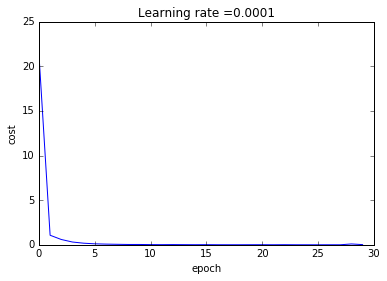

Train Accuracy: 1.0
Test Accuracy: 0.958333


In [10]:
parameters = model(X_train, Y_train, X_test, Y_test)

#### CNN performs much better than my homework using LR model in few epochs, and converge to a stable much faster
which the accuray is:

Cost after epoch 0: 1.855702

Cost after epoch 100: 1.016458

Cost after epoch 200: 0.733102

Cost after epoch 300: 0.572940

Cost after epoch 400: 0.468774

Cost after epoch 500: 0.381021

Cost after epoch 600: 0.313822

Cost after epoch 700: 0.254158

Cost after epoch 800: 0.203829

Cost after epoch 900: 0.166421

Cost after epoch 1000: 0.141486

Cost after epoch 1100: 0.107580

Cost after epoch 1200: 0.086270

Cost after epoch 1300: 0.059371

Cost after epoch 1400: 0.052228


Train Accuracy: 0.999074

Test Accuracy: 0.716667
<img src="out/homework.png" style="width:387px;height:281px;">
